#### IBM Quantum / © 2022 IBM Corporation
#### IBM Existing Work
#### IBM Confidential

In [5]:
from qiskit import Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.quantum_info.states import partial_trace
from qiskit.circuit import ParameterVector, Parameter

import math as math
import numpy as np
import matplotlib.pyplot as plt

<h1>Variational Quantum Linear Solver (VQLS)</h1>

## 1. Introduction

The Variational Quantum Linear Solver, or the VQLS, is a quantum algorithm that uses a variational scheme to solve systems of linear equations. 
Specifically, if we are given some matrix $\textbf{A}$, such that $\textbf{A} \textbf{x} \ = \ \textbf{b}$, where 
$\textbf{b}$ is some known vector, the VQLS algorithm attempts to find $\textbf{x}$ that is proportional to the 
actual solution. Such an algorithm can be run on near-term devices and recent studies indicate that VQLS has a better 
runtime-scaling (empirically obtained) compared to the classical schemes.<sup>[1](#Bravo-Prieto2020)</sup>

## 2. Algorithm

Let's make some assumptions first about the form of $\textbf{A}$ and $\textbf{b}$. . The first assumption is that the 
matrix $\textbf{A}$ is Hermitian, $A \in \mathbb{C}^{N \times N}$ can always be expressed as linear combination of unitaries 
i.e. $A = \sum_{i=0}^{m-1} c_i A_i$ where 
$c_i$ are real numbers and each $A_i$ is an unitary. We assume that such a decomposition is presented to us. Also, 
we assume that the vector $\textbf{b}=\{b_0, b_1, b_2, \cdots, b_{N-1}\}$,  
$c_i$ are real numbers and each $A_i$ is an unitary. Later we discuss, how one can acheive such a decomposition. Also, 
we assume that the vector $\textbf{b}=(b_0, b_1, b_2, \cdots, b_{N-1})$ 
can be loaded to a quantum state 
$\lvert b \rangle = \frac{1}{\sum_{j=0}^{N-1} \lvert b_i \rvert^2} \sum_{i=0}^{N-1} b_i \lvert i \rangle$ using a suitable unitary $U$. 
Hence,

$$\lvert b \rangle = U \lvert 0 \rangle$$
Now, the goal is to prepare a quantum state $\lvert x\rangle$ such that $A\lvert x\rangle = \lvert b \rangle$. 
As a step towards finding $\lvert x\rangle$, the algorithm prepares a trial state using a parametrized 
unitary $V(\boldsymbol{\theta}).$ Hence,

$$\lvert \psi(\boldsymbol{\theta}) \rangle = V(\boldsymbol{\theta}) \lvert 0 \rangle.$$

The goal then is to find parameters $\boldsymbol{\theta}$ such that the distance between the state 
$A\lvert \psi(\boldsymbol{\theta}) \rangle$ and $\lvert b \rangle$ is
minimized. One such measure between the quantum states is the fidelity measure $F$ which is defined between two pure states as 
$\lvert a \rangle$ and $\lvert b \rangle$ as $\lvert \langle a \lvert b \rangle \rvert^2$. Note that because of $A$ not being 
an unitary, the norm of $A\lvert \psi(\boldsymbol{\theta}) \rangle$ is not expected to be unity. As a result we would work 
with $\frac{1}{\lvert A\lvert \psi(\boldsymbol{\theta}) \rangle \rvert^2}A\lvert \psi(\boldsymbol{\theta}) \rangle$
Hence, we would like to maximize $F$, or minimize $1 - F$. The steps below show how $1-F$ can be further written in a form
so that the terms involved can be computed using a quantum circuit.
$$
\begin{align}
1 - F(\boldsymbol{\theta}) &=  1 - \frac{1}{\lvert A\lvert \psi(\boldsymbol{\theta}) \rangle \rvert^2}\lvert 
(A\lvert \psi(\boldsymbol{\theta}) \rangle)^{\dagger} \lvert b \rangle \rvert^2 
\\
&= 1 - \frac{1}{\lvert A\lvert \psi(\boldsymbol{\theta}) \rangle \rvert^2}
\lvert \langle  \psi(\boldsymbol{\theta}) \rvert A^{\dagger} \lvert b \rangle \rvert^2
\\
&= 1 - \frac{1}{\lvert A\lvert \psi(\boldsymbol{\theta}) \rangle \rvert^2}
\lvert \langle  \psi(\boldsymbol{\theta}) \rvert A^{\dagger} U \lvert 0 \rangle \rvert^2
\\
&= 1 - \frac{1}{\lvert A\lvert \psi(\boldsymbol{\theta}) \rangle \rvert^2}
\lvert (V(\boldsymbol{\theta}) \lvert 0 \rangle)^{\dagger} A^{\dagger} U \lvert 0 \rangle \rvert^2
\end{align}
$$

As, we have $A = \sum_{i=0}^{m-1} c_i A_i$, we can further write the above expression as
$$
\begin{align}
&= 1 - \frac{1}{\lvert A\lvert \psi(\boldsymbol{\theta}) \rangle \rvert^2}
\lvert \sum_{i=0}^{M-1} c_i \langle 0 \rvert V(\boldsymbol{\theta})^{\dagger} A_i^{\dagger} U \lvert 0 \rangle \rvert^2 
\\
&= 1 - \frac{1}{(A\lvert \psi(\boldsymbol{\theta}) \rangle)^{\dagger} A\lvert \psi(\boldsymbol{\theta}) \rangle}
\big( \sum_{i=0}^{M-1} c_i \langle 0 \rvert V(\boldsymbol{\theta})^{\dagger} A_i^{\dagger} U \lvert 0 \rangle \big)
\big(\sum_{j=0}^{N-1} c_j \langle 0 \rvert V(\boldsymbol{\theta})^{\dagger} A_j^{\dagger} U \lvert 0 \rangle\big)^{\dagger} 
\\
&= 1 - \frac{1}{\langle \psi(\boldsymbol{\theta})\rvert A^{\dagger} A\lvert \psi(\boldsymbol{\theta}) \rangle}
\sum_{i=0}^{M-1} \sum_{j=0}^{N-1} c_i c_j^{*} \langle 0 \rvert V(\boldsymbol{\theta})^{\dagger} A_i^{\dagger} U 
\lvert 0 \rangle \langle 0 \lvert U^{\dagger} A_j V(\boldsymbol{\theta}) \lvert 0 \rangle  
\end{align}
$$

### Computation of terms

Now, lets focus on the term in the numerator of the expression above, $L(\boldsymbol{\theta}) 
= \langle 0 \rvert V(\boldsymbol{\theta})^{\dagger} A_i^{\dagger} 
U \lvert 0 \rangle \langle 0 \lvert U^{\dagger} A_j V(\boldsymbol{\theta}) \lvert 0 \rangle$. 

In the original paper,<sup>[1](#Bravo-Prieto2020)</sup> the projection operator $\lvert 0 \rangle \langle 0 \lvert$ is substituted by another "local" 
operator

$$
\frac{1}{2} + \frac{1}{2n}{\sum_{i=0}^{n-1} Z_i}.
$$
Such a local version of the cost function leads to further simplification of the circuit (see below) and is expected to present 
a more amenable minimization landscape <sup>[1](#Bravo-Prieto2020)</sup>.

It leads to the fidelity expression as

$$
\begin{split}
1 - F_l(\boldsymbol{\theta}) &= 1 - \frac{1}{\langle \psi(\boldsymbol{\theta})\rvert A^{\dagger} A\lvert \psi(\boldsymbol{\theta}) 
                                             \rangle}
\sum_{i=0}^{M-1} \sum_{j=0}^{N-1} c_i c_j^{*} \langle 0 \rvert V(\boldsymbol{\theta})^{\dagger} A_i^{\dagger} U 
\big(\frac{1}{2} + \frac{1}{2n}{\sum_{k=0}^{n-1} Z_k}\big) U^{\dagger} A_j V(\boldsymbol{\theta}) \lvert 0 \rangle 
\\
&= 1 - \frac{1}{\langle \psi(\boldsymbol{\theta})\rvert A^{\dagger} A\lvert \psi(\boldsymbol{\theta}) \rangle}
\big(\frac{1}{2}\sum_{i=0}^{M-1} \sum_{j=0}^{N-1} c_i c_j^{*} \langle 0 \rvert 
V(\boldsymbol{\theta})^{\dagger} 
A_i^{\dagger} U U^{\dagger} A_j V(\boldsymbol{\theta}) \lvert 0 \rangle + \frac{1}{2n}\sum_{i=0}^{M-1} \sum_{j=0}^{N-1} 
     \sum_{k=0}^{n-1} c_i c_j^{*} \langle 0 \rvert 
V(\boldsymbol{\theta})^{\dagger} 
A_i^{\dagger} U Z_k U^{\dagger} A_j V(\boldsymbol{\theta}) \lvert 0 \rangle \big) \\
&= 1 - \frac{1}{\langle \psi(\boldsymbol{\theta})\rvert A^{\dagger} A\lvert \psi(\boldsymbol{\theta}) \rangle}
\big(\frac{1}{2} \langle \psi(\boldsymbol{\theta})\rvert A^{\dagger} A\lvert \psi(\boldsymbol{\theta}) \rangle 
     + \frac{1}{2n}\sum_{i=0}^{M-1} \sum_{j=0}^{N-1} \sum_{k=0}^{n-1} c_i c_j^{*} \langle 0 \rvert 
V(\boldsymbol{\theta})^{\dagger} 
A_i^{\dagger} U Z_k U^{\dagger} A_j V(\boldsymbol{\theta}) \lvert 0 \rangle \big) 
\\
&= \frac{1}{2} - 
\frac{1}{2n}\frac{\sum_{i=0}^{M-1} \sum_{j=0}^{N-1} \sum_{k=0}^{n-1} c_i c_j^{*} \langle 0 \rvert 
V(\boldsymbol{\theta})^{\dagger} 
A_i^{\dagger} U Z_k U^{\dagger} A_j V(\boldsymbol{\theta}) 
\lvert 0 \rangle}{\sum_{i=0}^{M-1} \sum_{j=0}^{N-1} c_i c_j^{*} \langle 0 \rvert 
V(\boldsymbol{\theta})^{\dagger} 
A_i^{\dagger} A_j V(\boldsymbol{\theta}) 
\lvert 0 \rangle} 
\\
\end{split} 
$$

Hence 
$$
\boxed{
1 - F_l(\boldsymbol{\theta}) = \frac{1}{2} - 
\frac{1}{2n}\frac{\sum_{i=0}^{M-1} \sum_{j=0}^{N-1} \sum_{k=0}^{n-1} c_i c_j^{*} \langle 0 \rvert 
V(\boldsymbol{\theta})^{\dagger} 
A_i^{\dagger} U Z_k U^{\dagger} A_j V(\boldsymbol{\theta}) 
\lvert 0 \rangle}{\sum_{i=0}^{M-1} \sum_{j=0}^{N-1} c_i c_j^{*} \langle 0 \rvert 
V(\boldsymbol{\theta})^{\dagger} 
A_i^{\dagger} A_j V(\boldsymbol{\theta}) 
\lvert 0 \rangle}}
$$
      
The quantity in the numerator and the denominator in the expression above can also be seen as 
expectations of the form $\langle \psi(\boldsymbol{\theta}) \rvert Q \lvert \psi(\boldsymbol{\theta}) \rangle$. 
Such expectations can be computed using a Hadamard test, as described below. The original paper uses Hadamard test to compute 
such expectations. 

#### Hadamard Test

The Hadamard test is a well-known method used to compute the expectations of the form $\langle \psi | U | \psi \rangle$,
where $U$ and $|\psi\rangle$ denote some arbitrary unitary and quantum state, respectively. The circuit below is used to compute
$Re(\langle \psi | U | \psi \rangle)$. A variant of the shown circuit can also be used to compute the 
$Img(\langle \psi | U | \psi \rangle)$.

<br><br>

<img src="./figs/hadamard_test.png" alt="alt text" width="800"/>

<br><br>

The probability of measuring the first qubit to be $0$ is equal to $\frac{1}{2} (1 \ + \ \text{Re}\langle U \rangle)$ and 
the probability of measuring $1$ is $\frac{1}{2} (1 \ - \ \text{Re}\langle U \rangle)$, so subtracting the two 
probabilities gives us $\text{Re} \langle U \rangle$. The matrices we will be dealing with when we test 
this algorithm are completely real, so $\text{Re} \langle U \rangle \ = \ \langle U \rangle$, for this specific implementation. 
Here is how the Hadamard test works. By the circuit diagram, we have as our general state vector:

<br>



$$\frac{|0\rangle \ + \ |1\rangle}{\sqrt{2}} \ \otimes \ |\psi\rangle \ = \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}}$$



<br>

Applying our controlled unitary:

<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}}$$



<br>

Then applying the Hadamard gate to the first qubit:

<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{1}{2} \ \big[ |0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle \ + \ |0\rangle \ \otimes \ U|\psi\rangle \ - \ |1\rangle \ \otimes \ U|\psi\rangle \big]$$



<br>



$$\Rightarrow \ |0\rangle \ \otimes \ (I \ + \ U)|\psi\rangle \ + \ |1\rangle \ \otimes \ (I \ - \ U)|\psi\rangle$$



<br>

When we take a measurement of the first qubit, remember that in order to find the probability of measuring $0$, we must take the inner product of the state vector with $|0\rangle$, then multiply by its complex conjugate (see the quantum mechanics section if you are not familiar with this). The same follows for the probability of measuring $1$. Thus, we have:

<br>



$$P(0) \ = \ \frac{1}{4} \ \langle \psi | (I \ + \ U) (I \ + \ U^{\dagger}) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (I^2 \ + U \ + \ U^{\dagger} \ + \ U^{\dagger} U) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (2I \ + U \ + \ U^{\dagger}) |\psi\rangle$$



<br>



$$\Rightarrow \ \frac{1}{4} \Big[ 2 \ + \ \langle \psi | U^{\dagger} | \psi \rangle \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{4} \Big[ 2 \ + \ (\langle \psi | U | \psi \rangle)^{*} \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{2} (1 \ + \ \text{Re} \ \langle \psi | U | \psi \rangle)$$



<br>

By a similar procedure, we get:

<br>



$$P(1) \ = \ \frac{1}{2} \ (1 \ - \ \text{Re} \ \langle \psi | U | \psi \rangle)$$



<br>

And so, by taking the difference:

<br>



$$P(0) \ - \ P(1) \ = \ \text{Re} \ \langle \psi | U | \psi \rangle$$

<br>

### Circuit implementations

 Now let's discuss the actual implementation of Hadamard test in the current settings. As discussed before, we want to compute the
 numerator and the denominator in the expression of the fidelity derived above. 

$$
\boxed{
1 - F_l(\boldsymbol{\theta}) = \frac{1}{2} - 
\frac{1}{2n}\frac{\sum_{i=0}^{M-1} \sum_{j=0}^{N-1} \sum_{k=0}^{n-1} c_i c_j^{*} \langle 0 \rvert 
V(\boldsymbol{\theta})^{\dagger} 
A_i^{\dagger} U Z_k U^{\dagger} A_j V(\boldsymbol{\theta}) 
\lvert 0 \rangle}{\sum_{i=0}^{M-1} \sum_{j=0}^{N-1} c_i c_j^{*} \langle 0 \rvert 
V(\boldsymbol{\theta})^{\dagger} 
A_i^{\dagger} A_j V(\boldsymbol{\theta}) 
\lvert 0 \rangle}}
$$

#### Computation of the numerator
Each term in the numerator can be obtained by a Hadamard test circuit. Here we show the circuit implementation that would allow 
computation of real part of the term. Another circuit would be needed to compute the imaginary part.

<img src="./figs/vqls.png" alt="alt text" width="1000"/>

This circuit can be further simplified by $\text{c-}U^{\dagger}\text{c-}Z\text{c-}U = U^{\dagger} (\text{c-}Z) U$. This simplification is beneficial because it removes two control gates that are costly to implement in hardware. This trick of dropping the controls on $U$ and $U^{\dagger}$ is allowed because $U U^{\dagger} = I$ in the simplified circuit, which is equivalent to the control qubit $q_0$ acting in the zero state $\vert 0 \rangle$ in the prior circuit. Hence, the circuit above can be further simplified as

<img src="./figs/vqls-simple.png" alt="alt text" width="1000"/>

#### Computation of the denominator

Each term in the denominator can be computed by a circuit of the form shown below. Again, we only show the circuit for obtaining 
real part of the terms.

<img src="./figs/denominator.png" alt="alt text" width="700"/>

### Coding an implementation in Qiskit

Let's define a toy problem we would implement in Qiskit. We consider solving $A\lvert x \rangle = \lvert b \rangle$ where

$$A = c_0 A_0 + c_1 A_1$$ where $A_0 = I \otimes I \otimes I$ and 
$A_1 = Z \otimes X \otimes I.$ We consider,


$$ \lvert b \rangle = H^{\otimes 3} \lvert 000 \rangle$$

The construct discussed above can be used to compute fidelities using Hadamard tests. But for matrix $A$ which can be expressed
as $M$ unitaries, ~$M^2 (n + 1)$ circuits are needed. In order to reduce the number of circuits that is required in the original 
VQLS scheme, here, we consider an alternative scheme to implement $A$.

One can construct a circuit that implements $A \lvert \psi(\theta) \rangle$ in one go, instead of working 
with the combinations of $A$ separately as was done in the 
original paper. This can be done, as described below, by using an ancilla qubit that allows rotations to encode the 
coefficients $c_i$ in the linear combination of $A = \sum_i c_i A_i$.

We work it out below for our toy model problem where $A = c_0 A_0 + c_1 A_1$. 
However, such a construct can be easily generalized to a sum involving more than two terms.<sup>[2](#Childs2012)</sup>


Let $A = c_0 A_0 + c_1 A_1$, where $A_0$ and $A_1$ are unitaries. We introduce $\zeta$, so that $\cos(\zeta) = \sqrt{\frac{c_0}{|c_0| + |c_1|}}$ and $\sin(\zeta) = \sqrt{\frac{c_1}{|c_0| + |c_1|}}$. The denominator is the L1 norm $|c_0| + |c_1|$.

 <img src="./figs/lcu.png" alt="alt text" width="1200"/>

The set of transformations (shown above) we plan to do are

$$
\begin{aligned}
& |0\rangle V(\theta)|0\rangle \mapsto R_Y(\zeta) |0\rangle V(\theta) |0\rangle \\
& \mapsto \bigg(\cos(\zeta)|0\rangle + \sin(\zeta) |1\rangle\bigg) V(\theta)|0\rangle \\
& \mapsto  \cos(\zeta) |0\rangle A_{0} V(\theta)|0\rangle 
+ \sin(\zeta) |1\rangle A_{1} V(\theta)|0\rangle  \\
& \mapsto |0 \rangle \frac{c_0}{|c_0| + |c_1|} \big( c_0 A_{0} + c_1 A_{1} \big) V(\theta)|0\rangle 
- |1\rangle \frac{\sqrt{c_0 c_1}} {|c_0| + |c_1|} \big(A_{0} - A_{1} \big) V(\theta) |0\rangle 
\end{aligned}
$$

where $R_Y(\zeta) = e^{-i \zeta Y}$.

It is clear that $A \lvert \psi(\theta) \rangle$ is implemented on the second register upto a multiplicative factor. 

In the next step, we would hit the bottom register with $U^{\dagger}$. Recall $U \lvert 0 \rangle = \lvert b \rangle.$
Hence, $U^{\dagger} \lvert b \rangle = \lvert 0 \rangle$. The resulting state now

$$
\mapsto |0\rangle \frac{c_0}{|c_0| + |c_1|} U^{\dagger} \big(c_0 A_{0} + c_1 A_{1} \big) V(\theta)|0\rangle 
- |1\rangle \frac{\sqrt{c_0 c_1}} {|c_0| + |c_1|} U^{\dagger} \big(A_{0} - A_{1} \big) V(\theta) |0\rangle
$$

The state left after measuring zero on the ancilla qubit is

$$
  |\Psi(\theta)\rangle = U^{\dagger} \frac{c_0}{|c_0| + |c_1|} \big(c_0 A_{0} + c_1 A_{1} \big) V(\theta)|0\rangle 
$$


The probability of observing all zero state in another set of measurements on the second register is 

$$
\begin{align}
P(0|\text{ancilla in zero state}) &=  \frac{c_0^2}{(|c_0| + |c_1|)^2} \langle 0 | V^{\dagger}(\theta)\bigg(c_0 A_{0}^{\dagger} 
+ c_1 A_{1}^{\dagger} \bigg) U | 0 \rangle \langle 0 | U^{\dagger}\bigg(c_0 A_{0} 
+ c_1 A_{1} \bigg) V(\theta)|0\rangle \\
&= \frac{c_0^2}{(|c_0| + |c_1|)^2} \langle \psi(\theta) | A^{\dagger} |b \rangle \langle b| A | \psi(\theta) \rangle \\ 
\end{align} 
$$

Hence, we can interpret the probability as fidelity between states $A |\psi(\theta)\rangle$ and $|b\rangle$. Note that in order
for a scheme like this to succeed, we would like to have create enough copies of the final state so that we measure 
zero state on the ancilla qubit with some non-zero probability. 

The probability of failure i.e. probability of observing "one" state on the ancilla qubit is 

$$
\begin{split}
P(1) &= \frac{c_0 c_1}{(|c_0| + |c_1|)^2} \bigg \lVert \big(A_{0} - A_{1} \big) V(\theta) |0\rangle \bigg \rVert^2 \\
&\le \frac{c_0 c_1}{(|c_0| + |c_1|)^2} \bigg \lVert A_{0} - A_{1} \bigg \rVert^2 
\bigg \lVert V(\theta) |0\rangle \bigg \rVert^2 \\
&= \frac{c_0 c_1}{(|c_0| + |c_1|)^2} \bigg \lVert A_{0} - A_{1}\bigg \rVert^2 \\
&\le \frac{4 c_0 c_1}{(|c_0| + |c_1|)^2}
\end{split}
$$
Hence, one needs to run this scheme (create copies of quantum state) more than $ \frac{(|c_0| + |c_1|)^2}{4 c_0 c_1}$ times to ensure that a zero state is
observed on the ancilla atleast once. A more general treatment when $A = \sum_i c_i A_i$ can be found in Ref <sup>[2](#Childs2012)</sup>.

## Qiskit code for the toy problem 

In [6]:
# Define global  parameters

# Number of system qubits
n_qubits = 3  

# Number of parameterized unitary circuits
num_alpha = 3 

# Addition of an ancillary qubit
tot_qubits = n_qubits+1  

# Seed for random number generator for the ansatz
rng_seed = 0  

# A matrix coefficient
init_cm = np.array([1, 0.2])

# conversion of the coefficient
norm = np.linalg.norm(init_cm, 1)

c_norm = init_cm / norm
n00 = np.sqrt(init_cm[0]/norm) 
theta = np.arccos(n00)
n01 = np.sin(theta)
cnorm_list = [n00, n01]

#nshots, set 1000 more than minimum needed (see discussion above)
Nshots = 1000 + int((cnorm_list[0] ** 2 + cnorm_list[1] ** 2) ** 2 / 4 * cnorm_list[0] * cnorm_list[1])

### Define functions

In [7]:
def A_weight_circuits(total_qubits, theta, amp_swap):
    
    """
    Y-rotations to implement coefficients of A_0 and A_1
    
    total_qubits: int
            circuit width
    theta: float
        angle of rotation based on coefficients of A
    amp_swap: bool
        The amp_swap argument determines with the forward Ry gate 
            (amp_swap=0) or inverse Ry gate (amp_swap=1) is used.
    """
    
    ancilla_idx =  total_qubits -1
    qc_input = QuantumCircuit(total_qubits)

    if amp_swap == 0:
        qc_input.ry(-2 * theta, ancilla_idx)
    elif amp_swap == 1:
        qc_input.ry(2 * theta, ancilla_idx)
    
    return qc_input


def Cont_A(total_qubits, idx):
    
    """
    Implements A's components A_0 and A_1
    """
    
    ancilla_idx =  total_qubits - 1
    qc = QuantumCircuit(total_qubits)
    
    if idx == 0:        
        pass
    elif idx == 1:
        qc.cz(ancilla_idx, 0)
        qc.cx(ancilla_idx, 1)
    
    return qc


def fixed_ansatz(n_qubits, alpha):
    
    """
    Prepares an estimate of the solution state |x>
    """
    
    circ = QuantumCircuit(n_qubits)

    for idx, element in enumerate(alpha):
        circ.h(idx)
        circ.ry(element, idx)
        
    return circ


def vqls_block(n_qubits, theta, cnorm_list, sim_f, alpha):
    
    """
    Main VQLS quantum circuit block
    """
    
    total_qubits = n_qubits + 1
    
    qreg = QuantumRegister(total_qubits)
    creg = ClassicalRegister(total_qubits)
    
    qc = QuantumCircuit(qreg,creg)
    
   # ancilla circuilt for the coefficient
    qc_init = A_weight_circuits(tot_qubits,theta,0)
    qc.compose(qc_init, inplace = True)
    
    qc.barrier()

    # first circuit (1) : to generate /X> from Ansatz
    qc_ansatz = fixed_ansatz(n_qubits, alpha)
    qc.compose(qc_ansatz, inplace = True)
    
    qc.barrier()
    
    # second circuit  (2) 
    # Controlled application of the unitary component A_m of the problem matrix A.
    for m in range(0, len(cnorm_list)):
        qc_A = Cont_A(total_qubits, m)
        qc.compose(qc_A, inplace = True)
        qc.barrier()

    # third circuit (3)
    qc_Ub = Ub(n_qubits)
    qc.compose(qc_Ub.inverse(), inplace = True)
    
    qc.barrier()
    
    # Inverse of weight cirucit
    qc_init_inv = A_weight_circuits(tot_qubits,theta,1)
    qc.compose(qc_init_inv, inplace = True)
    
    qc.barrier()
    
    if sim_f=="qasm":
        qc.measure([0,1,2,3],[0,1,2,3])
    
    return qc


def Ub(n_qubits):
    
    """
    Prepares state |b>
    """
    
    qc = QuantumCircuit(n_qubits)
    for idx in range(n_qubits):
        qc.h(idx)
    return qc


def measure(qc, weights, sim_f):
    
    """
    Gathers measurement counts
    """
    
    bind_dict = {}
    for key, idx in zip(qc.parameters, range(0, len(qc.parameters))):
        bind_dict[key] = weights[idx]
        
    final_cir = qc.bind_parameters(bind_dict)
    
    sim_f = sim_f
    
    
    if sim_f=="state":
    
        simulator = Aer.get_backend('statevector_simulator')
        result = execute(final_cir,backend = simulator, seed_transpiler=10).result()

        state_vector = result.get_statevector(final_cir)
        
        expected_value = state_vector[:1] * np.conj(state_vector[:1])
        expected_value = expected_value[0].real

        # partial trace
        
        H_out = np.outer(state_vector, np.conj(state_vector))
        rho_sub = partial_trace(H_out, [0,1,2]).data
        ancilla_density_mat_diag = np.diag(rho_sub)

        rho_sub = partial_trace(H_out, [3]).data
        work_density_mat_diag = np.diag(rho_sub)

        ancilla_zeros = ancilla_density_mat_diag[0].real
        
        if ancilla_zeros < 10 ** (-5):
            
            ancilla_zeros += 10 ** (-5)
        
        
        work_zeros = work_density_mat_diag[0].real
        
        all_zeros= (state_vector[0] * np.conj(state_vector[0])).real
        
        state_info=state_vector
        
    else:
        simulator = Aer.get_backend('qasm_simulator')
        result = execute(final_cir,backend = simulator,  shots=n_shots).result()
            

        # initialize dictionary
        counts_statevector =result.get_counts(final_cir)
        
        state_info =counts_statevector 
        
        # finding available states
        ancilla_zeros = sum([state_info[x] for x in state_info.keys() if x[0] =='0'])        

        try:
            ones = counts_statevector["1111"]
        except:
            ones = 0

        try:
            all_zeros = counts_statevector["0000"]
        except:
            all_zeros =0

        total = n_shots

    expected_value = all_zeros/ancilla_zeros
    
    return expected_value, state_info


def run_circuit(weights, theta, cnorm_list, sim_f):
    
    """
    Fetches fidelity
    """
    
    alpha = ParameterVector('alpha', n_qubits)
    circuit = vqls_block(n_qubits, theta,  cnorm_list =cnorm_list, sim_f=sim_f, alpha=alpha)
    expected_value, counts_statevector = measure(circuit, weights, sim_f)
    
    return expected_value, counts_statevector


def obj(weights, cnorm_list=None):
    """
    returns objective
    """
    sim_f="state"
    
    mu_real, counts_vector_r = run_circuit(weights, theta=theta, cnorm_list=cnorm_list, sim_f=sim_f)
    
    print("cost:", 1 - mu_real)
    
    return 1 - mu_real

### Run circuit

In [8]:
def answer_X_block(n_qubits, weights):
    
    qc = QuantumCircuit(n_qubits)
    qc_ansatz= fixed_ansatz(n_qubits, weights)
    qc.compose(qc_ansatz, inplace = True)  
    
    return qc


np.random.seed(rng_seed)
w = np.random.randn(n_qubits)

from scipy.optimize import minimize
options={'maxiter': 1000}
opt = minimize(obj, args=(cnorm_list), x0=w, tol=1e-6, method="COBYLA")
weights = opt.x

# prepare solution
circuit = answer_X_block(n_qubits, weights)
print(circuit)
simulator = Aer.get_backend('statevector_simulator')
result = execute(circuit,backend = simulator).result()
answer_X = result.get_statevector(circuit)

cost: 0.7446411231168404
cost: 0.9999359714044088
cost: 0.8916076827946845
cost: 0.901125947383221
cost: 0.18657773346058393
cost: 0.0626979085129864
cost: 0.16653014079362016
cost: 0.18655429617186225
cost: 0.2898017388942635
cost: 0.03792552025055018
cost: 0.07134799690305005
cost: 0.02132572123060794
cost: 0.016629219552737995
cost: 0.005075378108746698
cost: 0.002685840049026833
cost: 0.006013207734307691
cost: 0.007016884236906384
cost: 0.0030287822311539925
cost: 0.006858592569436217
cost: 0.0015649472499915662
cost: 0.0009434241275995126
cost: 0.0002473299286764874
cost: 8.251544251225429e-05
cost: 0.0003148411964065678
cost: 0.00013501458707132485
cost: 0.0002697557238713344
cost: 7.306687940022982e-05
cost: 0.00010007285565705182
cost: 2.4741246703929853e-05
cost: 7.417365771145157e-06
cost: 2.1084477553556802e-05
cost: 2.2457430049804827e-05
cost: 1.0299135781322022e-05
cost: 2.146326888119443e-05
cost: 6.579685950414138e-06
cost: 8.291822307660013e-06
cost: 2.739477563018511

### Check answer

/opt/anaconda3/envs/qiskit/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


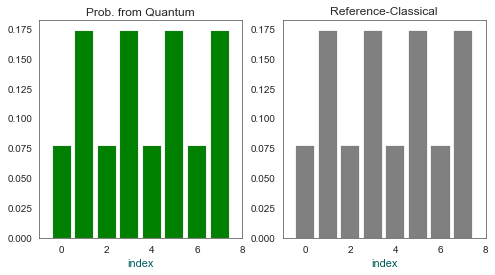

In [9]:
prob_X = np.multiply(answer_X, np.conj(answer_X))
prob_X

Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

A_0 = np.kron(np.kron(Id, Id), Id)

A_1 = np.kron(Id,np.kron(X, Z))

A_num = c_norm[0] * A_0 + c_norm[1] * A_1

b = np.ones(8) / np.sqrt(8)

A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)
reference_X = (x / np.linalg.norm(x))**2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), prob_X, color="#1192E8")
ax1.set_xlim(-1, 2 ** n_qubits)
ax1.set_xlabel("index")
ax1.set_title("Prob. from Quantum")

ax2.bar(np.arange(0, 2 ** n_qubits), reference_X, color="#005D5D")
ax2.set_xlim(-1, 2 ** n_qubits)
ax2.set_xlabel("index")
ax2.set_title("Reference-Classical")

plt.show()

In [7]:
import qiskit.tools.jupyter
%qiskit_version_table

### References

<a id='Bravo-Prieto2020'></a> 1. Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio, and Patrick J. Coles. Variational Quantum Linear Solver. [ArXiv]( https://arxiv.org/pdf/1909.05820.pdf) 2020

<a id='Childs2012'></a> 2. Andrew M. Childs, and Nathan Wiebe. Hamiltonian Simulation Using Linear Combinations of Unitary Operations. [ArXiv](https://arxiv.org/pdf/1202.5822.pdf) 2012